# Project 3

# Imports

In [1]:
from vpython import *
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplt
scene = canvas()
sphere()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Building Up to It
Here I am showing off some steps I took to build up to my full simulation.

Starting off with just a 2 ball 1 spring example.  
Into a full generalized example, but using many loops and little vectorization.  
Then less loops and more vectorization.  
And then finally no loops and all vectorization (besides generating a lookup table at simulation start using a loop).

## Two Ball one spring example

In [3]:
scene = canvas()

pos1 = -1
pos2 = 1
vel1 = 0.2
vel2 = 0
m1 = 1.0
m2 = 1.0
nomLength = 2
springConstant = 3

ball1 = sphere(pos=vector(-1,0,0), radius=0.4)
ball2 = sphere(pos=vector(1,0,0), radius=0.4)

dt = 0.01
t = 0
while t < 2:
    
    force1 = springConstant*(abs(pos2-pos1) - nomLength)
    force2 = springConstant*(nomLength - abs(pos1-pos2))
    
    vel1 += force1/m1*dt
    vel2 += force2/m2*dt
    pos1 += vel1*dt
    pos2 += vel2*dt
    
    ball1.pos.x=pos1
    ball2.pos.x=pos2
    
    ke = 0.5*m1*vel1**2 + 0.5*m2*vel2**2
    pe = 0.5*springConstant*(abs(pos2-pos1)-nomLength)**2
    # energy = ke+pe
    # print(energy)
    
    t += dt
    rate(1.0/dt)

<IPython.core.display.Javascript object>

## Update with no vectorization
```
# For each ball, for each ball
def update():
    global positions, velocities
    forces = np.zeros((N,N,N, 3))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                # For each ball, for each ball
                netForce = np.zeros((3))
                for conn in range(len(connectionLookup)):
                    if connections[i,j,k,conn]:
                        # print(f"{i},{j},{k}")
                        # print("connection: " + str(connectionLookup[conn]))
                        displacement = positions[tuple(np.array([i,j,k])+connectionLookup[conn])] - positions[i, j, k]
                        displacementMagnitude = np.linalg.norm(displacement)
                        displacementDirection = displacement / np.linalg.norm(displacement)
                        
                        realNominalLength = nominalLength * np.linalg.norm(connectionLookup[conn])
                        forceMagnitude = springConstant*(displacementMagnitude - realNominalLength)
                        forceVector = forceMagnitude * displacementDirection
                        netForce += forceVector
                forces[i,j,k]=netForce
    accelerations = (forces.T / masses).T
    velocities = velocities + accelerations*dt
    positions = positions + velocities*dt
```

## Update with partial vectorization
```
def update():
    global positions, velocities
    forces = np.zeros((N,N,N, 3))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                # For each ball, vectorized for each ball
                validConnections = connectionLookup[connections[i,j,k]==1]
                neighbors = np.array([i,j,k])+validConnections
                displacements = positions[tuple(neighbors[:,0]), tuple(neighbors[:,1]), tuple(neighbors[:,2])] - positions[i, j, k]
                displacementMagnitudes = np.linalg.norm(displacements, axis=1)
                displacementDirections = (displacements.T / displacementMagnitudes).T
                realNominalLengths = nominalLength * np.linalg.norm(validConnections, axis=1)
                
                forceMagnitudes = springConstant*(displacementMagnitudes - realNominalLengths)
                forceVectors = (forceMagnitudes * displacementDirections.T).T
                forces[i,j,k] = np.sum(forceVectors, axis=0)
                
    accelerations = (forces.T / masses).T
    velocities = velocities + accelerations*dt
    positions = positions + velocities*dt
```

### Original Connection Lookup Method
Code below defines the "connections" ndarray which is used in the two above update functions.  
The "connections" ndarray was my first attempt at verifying valid connections. It essentially was used as a mask on the connectionLookup list  
This method didn't work for full vectorization so had to be scrapped, but I do like this method.
```
connections = np.zeros((N,N,N,len(connectionLookup)))

Find valid connections for all objects
for i in range(N):
    for j in range(N):
        for k in range(N):
            for conn in range(len(connectionLookup)):
                connectedTo = [i+connectionLookup[conn, 0], j+connectionLookup[conn, 1], k+connectionLookup[conn, 2]]
                validConnection = 1
                for axis in range(3):
                    if connectedTo[axis] < 0 or connectedTo[axis] >= N:
                        validConnection = 0
                connections[i,j,k,conn] = validConnection
```

## Update fully vectorized
This code uses the neighborLookup table (defined in the Setup section) to index the positions ndarray in a way which yields otherPositions, a 18xNxNxNx3 ndarray which holds the position of everyneighbor of every object, and if the neighbor at that index would be out of bounds, it holds the position of itself, so when subtracted it will yield a 0 term which can be masked to ignore.
```
def update(positions, velocities, masses, neighborLookup, connectionLookup, nominalLength, springConstant, dt, method="semiBackwards"):
    otherPositions = positions[neighborLookup[:,:,:,:,0], neighborLookup[:,:,:,:,1], neighborLookup[:,:,:,:,2]]
    displacements = otherPositions - positions
    displacementMagnitudes = np.linalg.norm(displacements, axis=4)
    displacementsT = np.moveaxis(displacements,-1,0)
    displacementDirections = np.moveaxis(np.divide(displacementsT,displacementMagnitudes,out=np.zeros_like(displacementsT),where=displacementMagnitudes!=0),0,-1)
    
    realNominalLengths = nominalLength * np.linalg.norm(connectionLookup, axis=1)
    displacementMagnitudesT = np.moveaxis(displacementMagnitudes, 0, -1)
    forceMagnitudesT = np.subtract(displacementMagnitudesT, realNominalLengths, out=np.zeros_like(displacementMagnitudesT),where=displacementMagnitudesT!=0)
    forceMagnitudes = springConstant*np.moveaxis(forceMagnitudesT, -1, 0)
    
    forceVectors = np.moveaxis(np.moveaxis(displacementDirections, -1, 0) * forceMagnitudes, 0, -1)
    forces = np.sum(forceVectors, axis=0)
    
    accelerations = np.moveaxis(np.moveaxis(forces,-1,0) / masses, 0, -1)
    velocities = velocities + accelerations*dt
    positions = positions + velocities*dt
    return positions,velocities
```

# The whole shebang

## Functions

### Setup

In [4]:
def getLookups(shape):
    connectionsCardinal = [[0,0,1], [0,0,-1], [0,1,0], [0,-1,0], [1,0,0], [-1,0,0]]
    connectionsDiagonalXY = [[1,1,0], [1,-1,0], [-1,1,0], [-1,-1,0]]
    connectionsDiagonalXZ = [[1,0,1], [1,0,-1], [-1,0,1], [-1,0,-1]]
    connectionsDiagonalYZ = [[0,1,1], [0,1,-1], [0,-1,1], [0,-1,-1]]
    connectionLookup = np.array(connectionsCardinal+connectionsDiagonalXY+connectionsDiagonalXZ+connectionsDiagonalYZ)

    # need to have connectionLookup as primary axis to make broadcasting easier down the line
    neighborLookup = np.zeros((len(connectionLookup), shape[0], shape[1], shape[2], shape[3]), dtype=int)
    for l in range(len(connectionLookup)):
        for i in range(shape[0]):
            for j in range(shape[1]):
                for k in range(shape[2]):
                    neighborLookup[l,i,j,k] = np.array([i,j,k]) + connectionLookup[l]
                    if np.any(neighborLookup[l,i,j,k]<0) or np.any(neighborLookup[l,i,j,k]>=shape[:3]):
                        neighborLookup[l,i,j,k]=np.array([i,j,k])
                        
    return connectionLookup, neighborLookup

def initializeVisuals(shape, positions):
    spheres = []
    for i in range(shape[0]):
        spheres.append([])
        for j in range(shape[1]):
            spheres[i].append([])
            for k in range(shape[2]):
                spheres[i][j].append(sphere(pos=vector(positions[i,j,k,0], positions[i,j,k,1], positions[i,j,k,2]),
                        radius=0.2, color=vector(float(i+1)/(shape[0])+0.1,float(j+1)/(shape[1])+0.1,float(k+1)/(shape[2])+0.1)))
    return spheres

### Main

In [10]:
prevAccelerations = np.zeros((1))
def update(positions, velocities, masses, neighborLookup, connectionLookup, nominalLength, springConstant, dt, method="semiBackwards"):
    # Some stuff for integration
    global prevAccelerations
    if np.any(prevAccelerations.shape != positions.shape):
        prevAccelerations = np.zeros_like(positions)
    if method=="verlet":
        # at this point in the function, prevAccelerations=accelerations always
        positions = positions + velocities*dt + 0.5*prevAccelerations*dt**2
        
    # Main update code
    otherPositions = positions[neighborLookup[:,:,:,:,0], neighborLookup[:,:,:,:,1], neighborLookup[:,:,:,:,2]]
    displacements = otherPositions - positions
    displacementMagnitudes = np.linalg.norm(displacements, axis=4)
    displacementsT = np.moveaxis(displacements,-1,0)
    displacementDirections = np.moveaxis(np.divide(displacementsT,displacementMagnitudes,out=np.zeros_like(displacementsT),where=displacementMagnitudes!=0),0,-1)
    
    realNominalLengths = nominalLength * np.linalg.norm(connectionLookup, axis=1)
    displacementMagnitudesT = np.moveaxis(displacementMagnitudes, 0, -1)
    forceMagnitudesT = np.subtract(displacementMagnitudesT, realNominalLengths, out=np.zeros_like(displacementMagnitudesT),where=displacementMagnitudesT!=0)
    forceMagnitudes = springConstant*np.moveaxis(forceMagnitudesT, -1, 0)
    
    forceVectors = np.moveaxis(np.moveaxis(displacementDirections, -1, 0) * forceMagnitudes, 0, -1)
    forces = np.sum(forceVectors, axis=0)
    
    accelerations = np.moveaxis(np.moveaxis(forces,-1,0) / masses, 0, -1)
    
    # Integration
    # full backwards/implicit not possible
    # full trapezoid not possible
    if method=="forwards":
        positions = positions + velocities*dt
        velocities = velocities + accelerations*dt
    # elif method=="trapezoid":
    #     prevVelocities = velocities.copy()
    #     velocities = velocities + 0.5 * (accelerations + prevAccelerations)*dt
    #     positions = positions + 0.5 * (velocities + prevVelocities) * dt
    elif method=="semiTrapezoid":
        prevVelocities = velocities.copy()
        velocities = velocities = velocities + accelerations*dt
        positions = positions + 0.5 * (velocities + prevVelocities) * dt
    # Verlet like this only works when force is not a function of velocity. So doesnt work with damping
    elif method=="verlet":
        velocities = velocities + 0.5 * (prevAccelerations + accelerations) * dt
    # Do semiBackwards/semiImplicit by default, as its the simplest and stable
    else:
        velocities = velocities + accelerations*dt
        positions = positions + velocities*dt
    
    prevAccelerations = accelerations.copy()
    return positions,velocities
    
def show(shape, spheres, positions):
    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                spheres[i][j][k].pos.x = positions[i,j,k,0]
                spheres[i][j][k].pos.y = positions[i,j,k,1]
                spheres[i][j][k].pos.z = positions[i,j,k,2]
    return spheres

def simulate(shape=(3,3,3,3), nominalLength=1, springConstant=5, perturbationMagnitude=0.6, normalizePerturbations=False, basePosition=None, masses=None, dt=0.01, runTime=4, visualize=True, recordEnergy=False, plotEnergy=False, method="semiBackwards"):
    
    if basePosition == None:
        basePosition = np.array([int(-shape[0]/2),int(-shape[1]/2),int(-shape[2]/2)])
    if masses == None:
        masses = np.ones(shape[:3])

    # np.indices((N,N,N)).tranpose(1,2,3,0) Gets you ndarray where ndarray[i,j,k] = [i,j,k]
    positions = np.indices(shape[:3], dtype=float).transpose(1,2,3,0) * nominalLength + basePosition
    velocities = np.random.rand(shape[0],shape[1],shape[2],shape[3])*2*perturbationMagnitude - perturbationMagnitude
    # SUPER OVER ENGINEERED STUFF RIGHT HERE
    if normalizePerturbations:
        # Make sure net kinetic energy always starts at same value by dividing by entire magnitude of randomness
        velocities = np.moveaxis(np.moveaxis(velocities, -1, 0) / np.linalg.norm(velocities), 0, -1)
        # Because the entire magnitude will be higher when there are more balls, we need to scale
        # shape[0]*shape[1]*shape[2] is equal to the number of balls. We need a f(# of balls)
        # after some testing, I couldn't find the exact scaling function, but this works pretty well
        # note the presence of 0.693=ln(2), there is some connection between random numbers and natural log, not sure exactly
        velocities = (shape[0]*shape[1]*shape[2])**0.473*0.693*velocities


    connectionLookup, neighborLookup = getLookups(shape)
    
    if visualize:
        scene=canvas()
        spheres = initializeVisuals(shape, positions)

    print("Starting Simulation")
    if recordEnergy or plotEnergy:
        kineticEnergies, potentialEnergies = [],[]
    t = 0
    while t < runTime:

        positions, velocities = update(positions, velocities, masses, neighborLookup, connectionLookup, nominalLength, springConstant, dt, method=method)
        if visualize:
            spheres = show(shape, spheres, positions)
            rate(1.0/dt)
        if recordEnergy or plotEnergy:
            kineticEnergies.append(getKineticEnergy(velocities, masses))
            potentialEnergies.append(getPotentialEnergy(positions, neighborLookup, connectionLookup, nominalLength, springConstant))

        t += dt
        
    
    if plotEnergy:
        createEnergyPlot(kineticEnergies, potentialEnergies, runTime)
    
    if recordEnergy:
        return kineticEnergies, potentialEnergies

simulate(shape=(10, 10, 10, 3))

<IPython.core.display.Javascript object>

Starting Simulation


### Analysis

In [11]:
def getKineticEnergy(velocities, masses):
    magnitudes = np.linalg.norm(velocities, axis=3)
    return np.sum(np.square(magnitudes)*masses*0.5)

def getPotentialEnergy(positions, neighborLookup, connectionLookup, nominalLength, springConstant):
    xPos = neighborLookup[:,:,:,:,0]
    yPos = neighborLookup[:,:,:,:,1]
    zPos = neighborLookup[:,:,:,:,2]
    otherPositions = positions[xPos, yPos, zPos]
    displacements = otherPositions - positions
    displacementMagnitudes = np.linalg.norm(displacements, axis=4)
    displacementsT = np.moveaxis(displacements,-1,0)
    displacementDirections = np.moveaxis(np.divide(displacementsT,displacementMagnitudes,out=np.zeros_like(displacementsT),where=displacementMagnitudes!=0),0,-1)
    
    realNominalLengths = nominalLength * np.linalg.norm(connectionLookup, axis=1)
    displacementMagnitudesT = np.moveaxis(displacementMagnitudes, 0, -1)
    forceMagnitudesT = np.subtract(displacementMagnitudesT, realNominalLengths, out=np.zeros_like(displacementMagnitudesT),where=displacementMagnitudesT!=0)
    # Multiply by 0.25 instead of 0.5 because of double counting
    potentialEnergies = 0.25*springConstant*np.square(np.moveaxis(forceMagnitudesT, -1, 0))
    return np.sum(potentialEnergies)

def getTotalEnergy(positions, velocities, masses, neighborLookup, connectionLookup, nominalLength, springConstant):
    return getKineticEnergy(velocities, masses)+getPotentialEnergy(positions, neighborLookup, connectionLookup, nominalLength, springConstant)

def createEnergyPlot(kineticEnergies, potentialEnergies, runTime, plotOnlyTotal=False):
    pyplt.plot(np.linspace(0,runTime,len(kineticEnergies)), np.array(kineticEnergies)+np.array(potentialEnergies), label="Total")
    if not plotOnlyTotal:
        pyplt.plot(np.linspace(0,runTime,len(kineticEnergies)), kineticEnergies, label="Kinetic")
        pyplt.plot(np.linspace(0,runTime,len(kineticEnergies)), potentialEnergies, label="Potential")
    pyplt.xlabel('Time')
    pyplt.ylabel('Energy')
    pyplt.title('Net Energy in the Lattice Over Time')
    pyplt.legend()
    pyplt.show()

## Visual Simulation
### Choice of parameters and initial conditions
For my parameters like nominal length and spring constant. I just started with values of 1 and then adjusted to whatever I liked the most. I ended up keeping nominal length of 1, but changed spring constant to 5 for faster oscillations. Every parameter is adjustable as a parameter of the simulate function, the above values are just the defaults.

For initial conditions, I generate a random initial velocity for each object, and the magnitude of that velocity can be set as a parameter, but the default is 0.1 because I thought that yielded nice results.

In [20]:
simulate(shape=(8, 6, 4, 3), method="verlet")

<IPython.core.display.Javascript object>

Starting Simulation


### Results
This looks great! The balls oscillate around nicely as expected. I've also tested just setting a single ball to have initial velocity and the rest to start at 0, and as expected that single ball's velocity creates a ripple effect across the lattice until everything jiggles uniformly.

## Energy Confirmation
Here are sample energy plots, where you can see that the total energy stays consistent over time (with the default integration method, semi-implicit). In the next section there is comparison of integration methods. Also messing around with dt, I found that 0.01 seconds was a good default value.

Starting Simulation


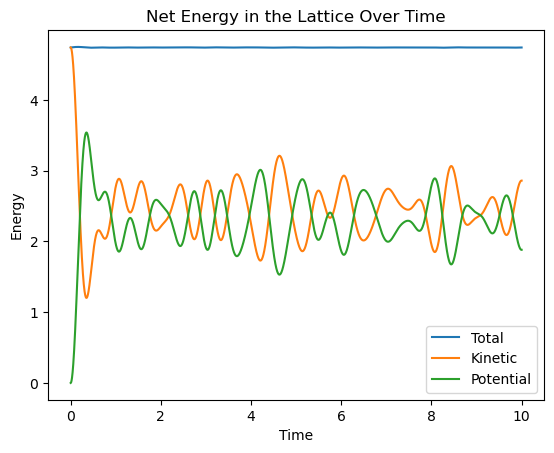

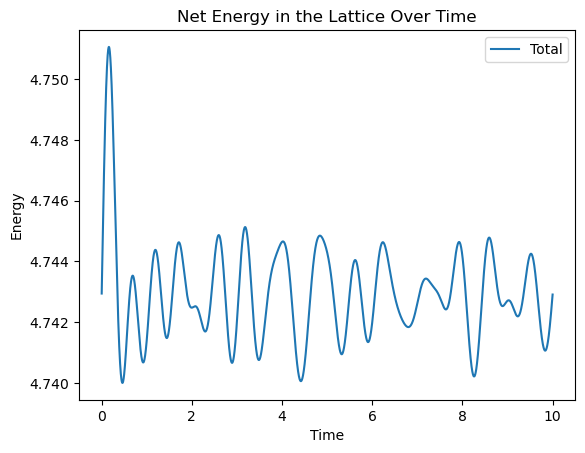

In [31]:
runTime = 10
ke, pe = simulate(visualize=False, recordEnergy=True, runTime=10)
createEnergyPlot(ke, pe, runTime, plotOnlyTotal=False)
createEnergyPlot(ke, pe, runTime, plotOnlyTotal=True)

## Integration Method Comparison

Starting Simulation
Starting Simulation
Starting Simulation
Starting Simulation


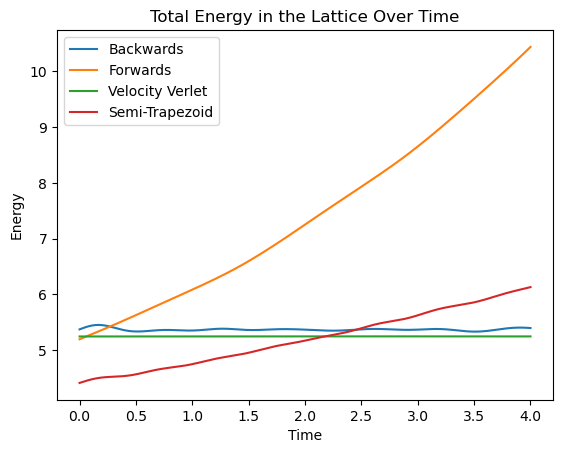

Starting Simulation
Starting Simulation
Starting Simulation
Starting Simulation


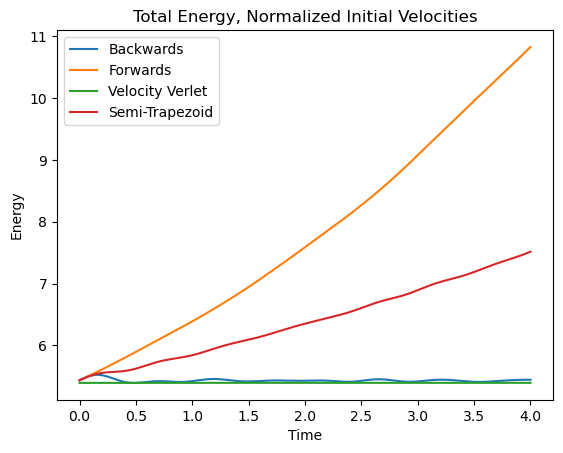

In [25]:
runTime=4
normalizePerturbations=False
ke, pe = simulate(visualize=False, recordEnergy=True, runTime=runTime, normalizePerturbations=normalizePerturbations)
pyplt.plot(np.linspace(0,runTime,len(ke)), np.array(ke)+np.array(pe), label="Backwards")
ke, pe = simulate(visualize=False, recordEnergy=True, runTime=runTime, method="forwards", normalizePerturbations=normalizePerturbations)
pyplt.plot(np.linspace(0,runTime,len(ke)), np.array(ke)+np.array(pe), label="Forwards")
ke, pe = simulate(visualize=False, recordEnergy=True, runTime=runTime, method="verlet", normalizePerturbations=normalizePerturbations)
pyplt.plot(np.linspace(0,runTime,len(ke)), np.array(ke)+np.array(pe), label="Velocity Verlet")
ke, pe = simulate(visualize=False, recordEnergy=True, runTime=runTime, method="semiTrapezoid", normalizePerturbations=normalizePerturbations)
pyplt.plot(np.linspace(0,runTime,len(ke)), np.array(ke)+np.array(pe), label="Semi-Trapezoid")


pyplt.xlabel('Time')
pyplt.ylabel('Energy')
pyplt.title('Total Energy in the Lattice Over Time')
pyplt.legend()
pyplt.show()

normalizePerturbations=True
ke, pe = simulate(visualize=False, recordEnergy=True, runTime=runTime, normalizePerturbations=normalizePerturbations)
pyplt.plot(np.linspace(0,runTime,len(ke)), np.array(ke)+np.array(pe), label="Backwards")
ke, pe = simulate(visualize=False, recordEnergy=True, runTime=runTime, method="forwards", normalizePerturbations=normalizePerturbations)
pyplt.plot(np.linspace(0,runTime,len(ke)), np.array(ke)+np.array(pe), label="Forwards")
ke, pe = simulate(visualize=False, recordEnergy=True, runTime=runTime, method="verlet", normalizePerturbations=normalizePerturbations)
pyplt.plot(np.linspace(0,runTime,len(ke)), np.array(ke)+np.array(pe), label="Velocity Verlet")
ke, pe = simulate(visualize=False, recordEnergy=True, runTime=runTime, method="semiTrapezoid", normalizePerturbations=normalizePerturbations)
pyplt.plot(np.linspace(0,runTime,len(ke)), np.array(ke)+np.array(pe), label="Semi-Trapezoid")


pyplt.xlabel('Time')
pyplt.ylabel('Energy')
pyplt.title('Total Energy, Normalized Initial Velocities')
pyplt.legend()
pyplt.show()

### Results
As expected the semi-implicit (backwards) and velocity verlet integration methods are numerically stable, and don't magnify any errors. Also as expected, the velocity verlet method is an order of magnitude better than the semi-implicit method. The forwards euler and semi-trapezoid (semi, because its only trapezoid for position, for velocity its forwards because knowing next state force is not practical) are unstable as expected, and result with the total energy being not at all constant. The forwards euler is the worst of them all which is also expected

# Adding Spring Damping

## Redfined Functions
The only thing we need to change to add spring damping is changing the force equation from:

$F=-kx$ to $F=-kx-bv$

Where $b$ is the damping constant and $v$ is the current velocity.

To make this change in the code, we simply subtract $bv$ from the forces ndarray. Seen in the line:

`forces = forces - dampingConstant*velocities`

In [9]:
prevAccelerations = np.zeros((1))
def updateWithDamping(positions, velocities, masses, neighborLookup, connectionLookup, nominalLength, springConstant, dampingConstant, dt, method="semiBackwards"):
    # Some stuff for integration
    global prevAccelerations
    if np.any(prevAccelerations.shape != positions.shape):
        prevAccelerations = np.zeros_like(positions)
    if method=="verlet":
        print("WARNING THIS FORM OF VERLET DOESNT WORK WHEN FORCE IS A FUNCTION OF VELOCITY")
        # at this point in the function, prevAccelerations=accelerations always
        positions = positions + velocities*dt + 0.5*prevAccelerations*dt**2
        
    # Main update code
    xPos = neighborLookup[:,:,:,:,0]
    yPos = neighborLookup[:,:,:,:,1]
    zPos = neighborLookup[:,:,:,:,2]
    otherPositions = positions[xPos, yPos, zPos]
    displacements = otherPositions - positions
    displacementMagnitudes = np.linalg.norm(displacements, axis=4)
    displacementsT = np.moveaxis(displacements,-1,0)
    displacementDirections = np.moveaxis(np.divide(displacementsT,displacementMagnitudes,out=np.zeros_like(displacementsT),where=displacementMagnitudes!=0),0,-1)
    
    realNominalLengths = nominalLength * np.linalg.norm(connectionLookup, axis=1)
    displacementMagnitudesT = np.moveaxis(displacementMagnitudes, 0, -1)
    forceMagnitudesT = np.subtract(displacementMagnitudesT, realNominalLengths, out=np.zeros_like(displacementMagnitudesT),where=displacementMagnitudesT!=0)
    forceMagnitudes = springConstant*np.moveaxis(forceMagnitudesT, -1, 0)
    
    forceVectors = np.moveaxis(np.moveaxis(displacementDirections, -1, 0) * forceMagnitudes, 0, -1)
    forces = np.sum(forceVectors, axis=0)
    forces = forces - dampingConstant*velocities
    
    accelerations = np.moveaxis(np.moveaxis(forces,-1,0) / masses, 0, -1)
    
    # Integration
    # full backwards/implicit not possible
    # full trapezoid not possible
    if method=="forwards":
        positions = positions + velocities*dt
        velocities = velocities + accelerations*dt
    # elif method=="trapezoid":
    #     prevVelocities = velocities.copy()
    #     velocities = velocities + 0.5 * (accelerations + prevAccelerations)*dt
    #     positions = positions + 0.5 * (velocities + prevVelocities) * dt
    elif method=="semiTrapezoid":
        prevVelocities = velocities.copy()
        velocities = velocities = velocities + accelerations*dt
        positions = positions + 0.5 * (velocities + prevVelocities) * dt
    # Verlet like this only works when force is not a function of velocity. So doesnt work with damping
    elif method=="verlet":
        velocities = velocities + 0.5 * (prevAccelerations + accelerations) * dt
    # Do semiBackwards/semiImplicit by default, as its the simplest and stable
    else:
        velocities = velocities + accelerations*dt
        positions = positions + velocities*dt
    
    prevAccelerations = accelerations.copy()
    return positions,velocities

def simulateWithDamping(shape=(3,3,3,3), nominalLength=1, springConstant=5, dampingConstant=1, perturbationMagnitude=0.6, normalizePerturbations=False, basePosition=None, masses=None, dt=0.01, runTime=4, visualize=True, recordEnergy=False, plotEnergy=False, method="semiBackwards"):
    
    if basePosition == None:
        basePosition = np.array([int(-shape[0]/2),int(-shape[1]/2),int(-shape[2]/2)])
    if masses == None:
        masses = np.ones(shape[:3])

    # np.indices((N,N,N)).tranpose(1,2,3,0) Gets you ndarray where ndarray[i,j,k] = [i,j,k]
    positions = np.indices(shape[:3], dtype=float).transpose(1,2,3,0) * nominalLength + basePosition
    velocities = np.random.rand(shape[0],shape[1],shape[2],shape[3])*2*perturbationMagnitude - perturbationMagnitude
    # SUPER OVER ENGINEERED STUFF RIGHT HERE
    if normalizePerturbations:
        # Make sure net kinetic energy always starts at same value by dividing by entire magnitude of randomness
        velocities = np.moveaxis(np.moveaxis(velocities, -1, 0) / np.linalg.norm(velocities), 0, -1)
        # Because the entire magnitude will be higher when there are more balls, we need to scale
        # shape[0]*shape[1]*shape[2] is equal to the number of balls. We need a f(# of balls)
        # after some testing, I couldn't find the exact scaling function, but this works pretty well
        # note the presence of 0.693=ln(2), there is some connection between random numbers and natural log, not sure exactly
        velocities = (shape[0]*shape[1]*shape[2])**0.473*0.693*velocities


    connectionLookup, neighborLookup = getLookups(shape)
    
    if visualize:
        scene=canvas()
        spheres = initializeVisuals(shape, positions)

    print("Starting Simulation")
    if recordEnergy or plotEnergy:
        kineticEnergies, potentialEnergies = [],[]
    t = 0
    while t < runTime:

        positions, velocities = updateWithDamping(positions, velocities, masses, neighborLookup, connectionLookup, nominalLength, springConstant, dampingConstant, dt, method=method)
        if visualize:
            spheres = show(shape, spheres, positions)
            rate(1.0/dt)
        if recordEnergy or plotEnergy:
            kineticEnergies.append(getKineticEnergy(velocities, masses))
            potentialEnergies.append(getPotentialEnergy(positions, neighborLookup, connectionLookup, nominalLength, springConstant))

        t += dt
        
    
    if plotEnergy:
        createEnergyPlot(kineticEnergies, potentialEnergies, runTime)
    
    if recordEnergy:
        return kineticEnergies, potentialEnergies

## Simulation

<IPython.core.display.Javascript object>

Starting Simulation


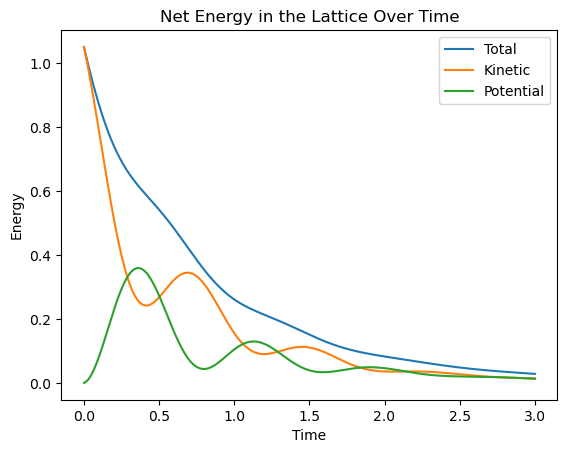

In [10]:
simulateWithDamping(shape=(2,2,2,3),plotEnergy=True, runTime=3, method="a")

## Results
This also works as expected! When you run the simulation, the balls start out jiggling more aggressively because of their initial perturbation, but then as time goes on the damping slows them down until they reach a stand still. This is reflected in the graph of the energies, there the total energy decreases over time like an exponential decay, and the kinetic and potential energies decrease over time more like damped sinusoids (i.e. $e^{-t}cos(t+\phi)$) which is also expected.